In [1]:
import json
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib import rc
import random

In [2]:
# matplotlib 한글 폰트 깨짐 문제 해결
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fontprop = fm.FontProperties(fname=font_path)

In [4]:
# 경로 설정

data_path = '/workspace/Data_All/'

img_path = data_path + 'image/'                     # /workspace/Data_All/image/
json_path = data_path + 'label/'                    # /workspace/Data_All/label/
segment_path = data_path + 'segmentation/'          # /workspace/Data_All/segmentation/

sadness_img_path = img_path + 'sadness'                 # /workspace/Data_All/image/sadness/

In [5]:
# 라벨 정보 json 파일 (train, val, test 파일 통합)
# train_sadness.json + val_sadness.json + test_sadness.json -> json_sadness

# json 파일 각각 불러오기
with open (json_path + "train_sadness.json", "r", encoding='euc-kr') as f:
    json_sadness_train = json.load(f)
with open (json_path + "val_sadness.json", "r", encoding='euc-kr') as f:
    json_sadness_val = json.load(f)
with open (json_path + "test_sadness.json", "r", encoding='euc-kr') as f:
    json_sadness_test = json.load(f)

# 하나의 파일로 통합
json_sadness = []
if isinstance(json_sadness_train, list):
    json_sadness.extend(json_sadness_train)
if isinstance(json_sadness_val, list):
    json_sadness.extend(json_sadness_val)
if isinstance(json_sadness_test, list):
    json_sadness.extend(json_sadness_test)

In [6]:
len(json_sadness)     # 1500(train) + 300(val) + 300(test) = 2100

2100

In [8]:
# 이미지와 json 파일 내 이름이 일치하는지 확인

IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count

image_count = count_images_in_folder(sadness_img_path)
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_sadness)}")
print()

# 폴더 내 이미지 파일 이름 수집
def get_image_files_in_folder(folder_path):
    image_files = set()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_files.add(file)
    return image_files

# JSON 파일 내 이미지 파일 이름 수집
def get_image_files_in_json(json_file):
    json_filenames = {entry["filename"] for entry in json_file}
    return json_filenames

# 비교 수행
image_files_in_folder = get_image_files_in_folder(sadness_img_path)
image_files_in_json = get_image_files_in_json(json_sadness)

# 누락된 파일 찾기
missing_in_json = image_files_in_folder - image_files_in_json
missing_in_folder = image_files_in_json - image_files_in_folder

# 결과 출력 
print(f"JSON 파일에 없는 폴더 내 이미지 파일: {missing_in_json}")
print(f"폴더에 없는 JSON 파일의 이미지 파일: {missing_in_folder}")

폴더 내 이미지 파일 개수: 2100
json 파일 길이 : 2100

JSON 파일에 없는 폴더 내 이미지 파일: set()
폴더에 없는 JSON 파일의 이미지 파일: set()


In [9]:
json_sadness[0]

{'filename': 'xs3z4f15972eb0ebbb36f3e04654f4f5720614bfd8a5ba48231105a61ca6abmrz.jpg',
 'gender': '여',
 'age': 30,
 'isProf': '전문인',
 'faceExp_uploader': '슬픔',
 'bg_uploader': '문화재 및 유적지',
 'annot_A': {'boxes': {'maxX': 1582.139798564338,
   'maxY': 1530.6656109168403,
   'minX': 1059.6397382777686,
   'minY': 770.1475364515805},
  'faceExp': '슬픔',
  'bg': '문화재 및 유적지'},
 'annot_B': {'boxes': {'maxX': 1590.944141963225,
   'maxY': 1536.4190259647685,
   'minX': 1058.431567127683,
   'minY': 735.8697194897765},
  'faceExp': '기쁨',
  'bg': '실외 자연환경'},
 'annot_C': {'boxes': {'maxX': 1582.1160490782222,
   'maxY': 1530.5828999999997,
   'minX': 1045.1687509217786,
   'minY': 744.6512999999998},
  'faceExp': '중립',
  'bg': '실외 자연환경'}}

In [10]:
# Json 파일 -> DataFrame 변환
# df_sadness

# 데이터 변환 함수 정의
def process_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # annot_A, annot_B, annot_C 데이터 추가
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            row = {
                **base_info,
                'annot': annot_key,
                'faceExp': annot.get('faceExp'),
                'bg': annot.get('bg'),
                'minX': annot.get('boxes', {}).get('minX'),
                'minY': annot.get('boxes', {}).get('minY'),
                'maxX': annot.get('boxes', {}).get('maxX'),
                'maxY': annot.get('boxes', {}).get('maxY'),
            }
            processed_data.append(row)
    return pd.DataFrame(processed_data)

# 데이터프레임 생성
df_sadness = process_data(json_sadness)

In [ ]:
df_sadness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          6300 non-null   object 
 1   gender            6300 non-null   object 
 2   age               6300 non-null   int64  
 3   isProf            6300 non-null   object 
 4   faceExp_uploader  6300 non-null   object 
 5   bg_uploader       6300 non-null   object 
 6   annot             6300 non-null   object 
 7   faceExp           6300 non-null   object 
 8   bg                6300 non-null   object 
 9   minX              6300 non-null   float64
 10  minY              6300 non-null   float64
 11  maxX              6300 non-null   float64
 12  maxY              6300 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 640.0+ KB


In [ ]:
df_sadness

filename gender  age isProf  \
0     xs3z4f15972eb0ebbb36f3e04654f4f5720614bfd8a5ba...      여   30    전문인   
1     xs3z4f15972eb0ebbb36f3e04654f4f5720614bfd8a5ba...      여   30    전문인   
2     xs3z4f15972eb0ebbb36f3e04654f4f5720614bfd8a5ba...      여   30    전문인   
3     j3lrc2f227a917cd03e9177b2ce7da237e5d2a91a6e121...      남   20    일반인   
4     j3lrc2f227a917cd03e9177b2ce7da237e5d2a91a6e121...      남   20    일반인   
...                                                 ...    ...  ...    ...   
6295  ui3p18b12185fffde528c2a2fc801372b1e8e8f7a3727f...      여   20    일반인   
6296  ui3p18b12185fffde528c2a2fc801372b1e8e8f7a3727f...      여   20    일반인   
6297  0kldc0396782e2f25760f565f88712efb96270c07cb600...      여   40    일반인   
6298  0kldc0396782e2f25760f565f88712efb96270c07cb600...      여   40    일반인   
6299  0kldc0396782e2f25760f565f88712efb96270c07cb600...      여   40    일반인   

     faceExp_uploader        bg_uploader    annot faceExp                 bg  \
0                  슬픔          문화재 및 유적지  annot_A      슬픔          문화재 및 유적지   
1                  슬픔          문화재 및 유적지  annot_B      기쁨            실외 자연환경   
2                  슬픔          문화재 및 유적지  annot_C      중립            실외 자연환경   
3                  슬픔          숙박 및 거주공간  annot_A      슬픔          숙박 및 거주공간   
4                  슬픔          숙박 및 거주공간  annot_B      슬픔          숙박 및 거주공간   
...               ...                ...      ...     ...                ...   
6295               슬픔          숙박 및 거주공간  annot_B      슬픔          숙박 및 거주공간   
6296               슬픔          숙박 및 거주공간  annot_C      슬픔          숙박 및 거주공간   
6297               슬픔  교통/이동수단(엘리베이터 포함)  annot_A      슬픔  교통/이동수단(엘리베이터 포함)   
6298               슬픔  교통/이동수단(엘리베이터 포함)  annot_B      슬픔  교통/이동수단(엘리베이터 포함)   
6299               슬픔  교통/이동수단(엘리베이터 포함)  annot_C      슬픔  교통/이동수단(엘리베이터 포함)   

             minX        minY         maxX         maxY  
0     1059.639738  770.147536  1582.139799  1530.665611  
1     1058.431567  735.869719  1590.944142  1536.419026  
2     1045.168751  744.651300  1582.116049  1530.582900  
3     1175.315678  426.106320  1959.159700  1492.461900  
4     1121.595200  426.106320  1958.944300  1492.461900  
...           ...         ...          ...          ...  
6295   901.969733  174.593064  1639.564541  1265.945871  
6296   901.463171  164.588335  1647.465116  1264.057944  
6297  1088.600398  688.166957  1831.830598  1633.161257  
6298  1076.423398  690.237957  1829.516598  1637.568257  
6299  1082.653398  684.787957  1826.144598  1631.661257  

[6300 rows x 13 columns]

##### 표정 데이터 확인
- faceExp_uploader (image) 와 faceExp (annot) 차이 확인
- 표정 정보가 다른 이미지들 어떻게 처리할지

In [14]:
df_sadness['faceExp_uploader'].value_counts()


faceExp_uploader
슬픔    6300
Name: count, dtype: int64

In [15]:
df_sadness['faceExp'].value_counts()

faceExp
슬픔    4386
상처     655
불안     465
중립     449
분노     208
당황      80
기쁨      57
Name: count, dtype: int64

In [16]:
# faceExp가 슬픔이 아닌 데이터 추출
def process_non_panic_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # Process each annotation and filter for non-sadness faceExp
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            face_exp = annot.get('faceExp')
            if face_exp != "슬픔":  # Only include non-sadness faceExp
                row = {
                    **base_info,
                    'annot': annot_key,
                    'faceExp': face_exp,
                    'bg': annot.get('bg'),
                    'minX': annot.get('boxes', {}).get('minX'),
                    'minY': annot.get('boxes', {}).get('minY'),
                    'maxX': annot.get('boxes', {}).get('maxX'),
                    'maxY': annot.get('boxes', {}).get('maxY'),
                }
                processed_data.append(row)
    return pd.DataFrame(processed_data)

df_not_sadness = process_non_panic_data(json_sadness)

In [17]:
df_not_sadness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          1914 non-null   object 
 1   gender            1914 non-null   object 
 2   age               1914 non-null   int64  
 3   isProf            1914 non-null   object 
 4   faceExp_uploader  1914 non-null   object 
 5   bg_uploader       1914 non-null   object 
 6   annot             1914 non-null   object 
 7   faceExp           1914 non-null   object 
 8   bg                1914 non-null   object 
 9   minX              1914 non-null   float64
 10  minY              1914 non-null   float64
 11  maxX              1914 non-null   float64
 12  maxY              1914 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 194.5+ KB


In [18]:
df_not_sadness

filename gender  age isProf  \
0     xs3z4f15972eb0ebbb36f3e04654f4f5720614bfd8a5ba...      여   30    전문인   
1     xs3z4f15972eb0ebbb36f3e04654f4f5720614bfd8a5ba...      여   30    전문인   
2     plxg3fd368ea807fe7d76d986ed20c53d1db0d623c2603...      여   30    전문인   
3     887j5e59c505c555b892c184dd258555c910ea32781909...      남   40    일반인   
4     yobuc97955d53c85a7beb3e7107d739ae5eeef15c5ce93...      여   20    일반인   
...                                                 ...    ...  ...    ...   
1909  b36qc2a979d201466c67aca10618e181f3c4c2d2fca72c...      여   30    전문인   
1910  10vt463ed323acd213fd562fc226d0f8523af0a9ff298f...      여   30    일반인   
1911  10vt463ed323acd213fd562fc226d0f8523af0a9ff298f...      여   30    일반인   
1912  7khz65e33a9eb7303e38271d4d3e255353e32d75bf3a28...      여   20    일반인   
1913  7khz65e33a9eb7303e38271d4d3e255353e32d75bf3a28...      여   20    일반인   

     faceExp_uploader    bg_uploader    annot faceExp             bg  \
0                  슬픔      문화재 및 유적지  annot_B      기쁨        실외 자연환경   
1                  슬픔      문화재 및 유적지  annot_C      중립        실외 자연환경   
2                  슬픔      문화재 및 유적지  annot_B      중립        실외 자연환경   
3                  슬픔  스포츠 관람 및 레저시설  annot_C      불안  스포츠 관람 및 레저시설   
4                  슬픔   공공시설/종교/의료시설  annot_C      상처      숙박 및 거주공간   
...               ...            ...      ...     ...            ...   
1909               슬픔        행사/사무공간  annot_C      중립        행사/사무공간   
1910               슬픔        실외 자연환경  annot_A      중립          도심 환경   
1911               슬픔        실외 자연환경  annot_B      상처        실외 자연환경   
1912               슬픔     상업시설/점포/시장  annot_A      상처     상업시설/점포/시장   
1913               슬픔     상업시설/점포/시장  annot_B      상처     상업시설/점포/시장   

             minX        minY         maxX         maxY  
0     1058.431567  735.869719  1590.944142  1536.419026  
1     1045.168751  744.651300  1582.116049  1530.582900  
2      820.836505  265.655462  1209.728090   748.591309  
3      969.742223  418.063304  1658.548056  1365.153704  
4      995.724300  613.886000  2065.655300  1990.065400  
...           ...         ...          ...          ...  
1909  1318.717900  521.970900  2123.952100  1652.911600  
1910  1409.572300  858.845640  2023.913100  1603.097700  
1911  1409.655126  759.056956  2045.313093  1631.315506  
1912  1345.252024  289.722454  2162.161376  1425.240224  
1913  1339.063291  291.563533  2162.962025  1439.719183  

[1914 rows x 13 columns]

In [19]:
df_not_sadness['faceExp'].value_counts()

faceExp
상처    655
불안    465
중립    449
분노    208
당황     80
기쁨     57
Name: count, dtype: int64

Invalid SOS parameters for sequential JPEG


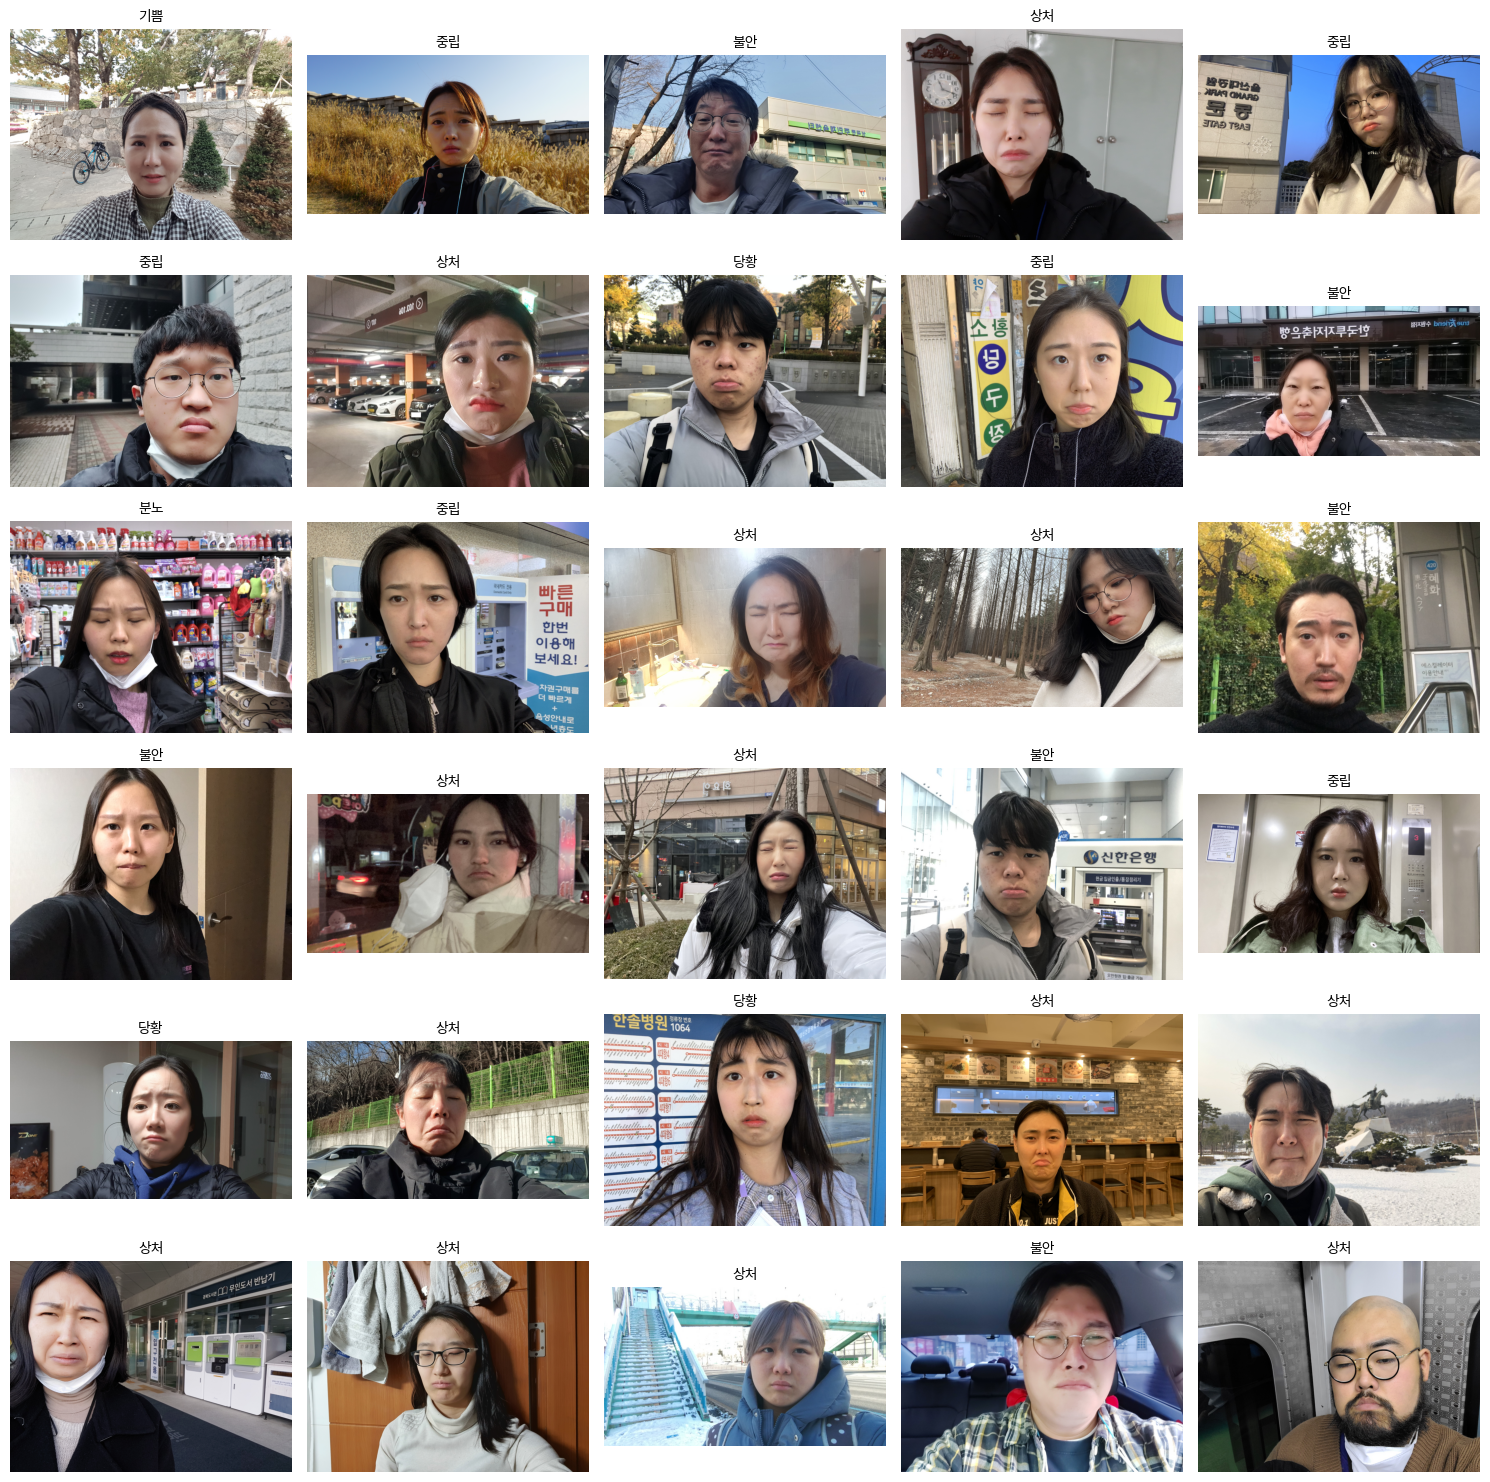

In [20]:
# 감정 정보가 다른 이미지 시각화
unique_filenames = df_not_sadness['filename'].unique()

plt.figure(figsize=(15, 15))

for i, filename in enumerate(unique_filenames):
    if i >= 30:  # Show only the first 30 images for this example
        break
    image_path = os.path.join(sadness_img_path, filename)
    if os.path.exists(image_path):  # Ensure the file exists
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(6, 5, i + 1)
        plt.imshow(image)
        faceExp = df_not_sadness[df_not_sadness['filename'] == filename]['faceExp'].iloc[0]
        plt.title(faceExp, fontproperties=fontprop)
        plt.axis('off')

plt.tight_layout()
plt.show()

##### 연령, 성별, 전문인 column 분포 확인

In [21]:
# 연령 분포 확인
df_sadness['age'].value_counts(), df_sadness['age'].value_counts(normalize=True)

(age
 20    3135
 30    2097
 40     810
 50     168
 10      84
 60       6
 Name: count, dtype: int64,
 age
 20    0.497619
 30    0.332857
 40    0.128571
 50    0.026667
 10    0.013333
 60    0.000952
 Name: proportion, dtype: float64)

In [22]:
# 성별 분포 확인
df_sadness['gender'].value_counts(), df_sadness['gender'].value_counts(normalize=True)

(gender
 여    3480
 남    2820
 Name: count, dtype: int64,
 gender
 여    0.552381
 남    0.447619
 Name: proportion, dtype: float64)

In [24]:
# 전문인 여부
df_sadness['isProf'].value_counts(), df_sadness['isProf'].value_counts(normalize=True)

(isProf
 일반인    3411
 전문인    2889
 Name: count, dtype: int64,
 isProf
 일반인    0.541429
 전문인    0.458571
 Name: proportion, dtype: float64)

##### 배경 정보 확인
- bg_uploader와 bg 차이 확인
- 배경 정보가 다른 이미지들 어떻게 처리할지

In [25]:
# 배경 정보
df_sadness['bg_uploader'].value_counts(), df_sadness['bg'].value_counts()

(bg_uploader
 숙박 및 거주공간            1212
 상업시설/점포/시장            954
 도심 환경                 801
 공공시설/종교/의료시설          747
 실외 자연환경               678
 교통/이동수단(엘리베이터 포함)     657
 문화재 및 유적지             339
 오락/공연시설               336
 행사/사무공간               303
 스포츠 관람 및 레저시설         273
 Name: count, dtype: int64,
 bg
 숙박 및 거주공간            1221
 상업시설/점포/시장           1108
 공공시설/종교/의료            893
 도심 환경                 741
 실외 자연환경               699
 교통/이동수단(엘리베이터 포함)     540
 행사/사무공간               348
 오락/공연시설               311
 스포츠 관람 및 레저시설         207
 문화재 및 유적지             205
 공공시설/종교/의료시설           27
 Name: count, dtype: int64)

##### 박스 좌표 정보 확인
- 한 이미지 내 박스 좌표가 유사한지 시각화 및 좌표 수치 확인

In [27]:
# 박스 A,B,C의 좌표 차이가 일정 수치 이상인 데이터 검출

# 차이 확인 함수
def is_significant_difference(boxA, boxB, boxC, threshold):
    def box_difference(box1, box2):
        return sum(abs(box1[key] - box2[key]) for key in box1)
    
    diff_AB = box_difference(boxA, boxB)
    diff_BC = box_difference(boxB, boxC)
    diff_CA = box_difference(boxC, boxA)
    
    return max(diff_AB, diff_BC, diff_CA) > threshold

# 유사하지 않은 데이터를 저장할 리스트
outlier_filenames = []

# 박스 좌표 분석
thershold = 500

for entry in json_sadness:
    annot_A = entry['annot_A']['boxes']
    annot_B = entry['annot_B']['boxes']
    annot_C = entry['annot_C']['boxes']
    
    if is_significant_difference(annot_A, annot_B, annot_C, thershold):
        outlier_filenames.append(entry['filename'])

# 결과 출력
print(f"outlier 파일 수:{len(outlier_filenames)}")

# outlier 데이터 추출 (json)
def extract_outliers(data, outlier_filenames):
    return [entry for entry in data if entry['filename'] in outlier_filenames]

outlier_json_sadness = extract_outliers(json_sadness, outlier_filenames)

outlier 파일 수:6


Invalid SOS parameters for sequential JPEG


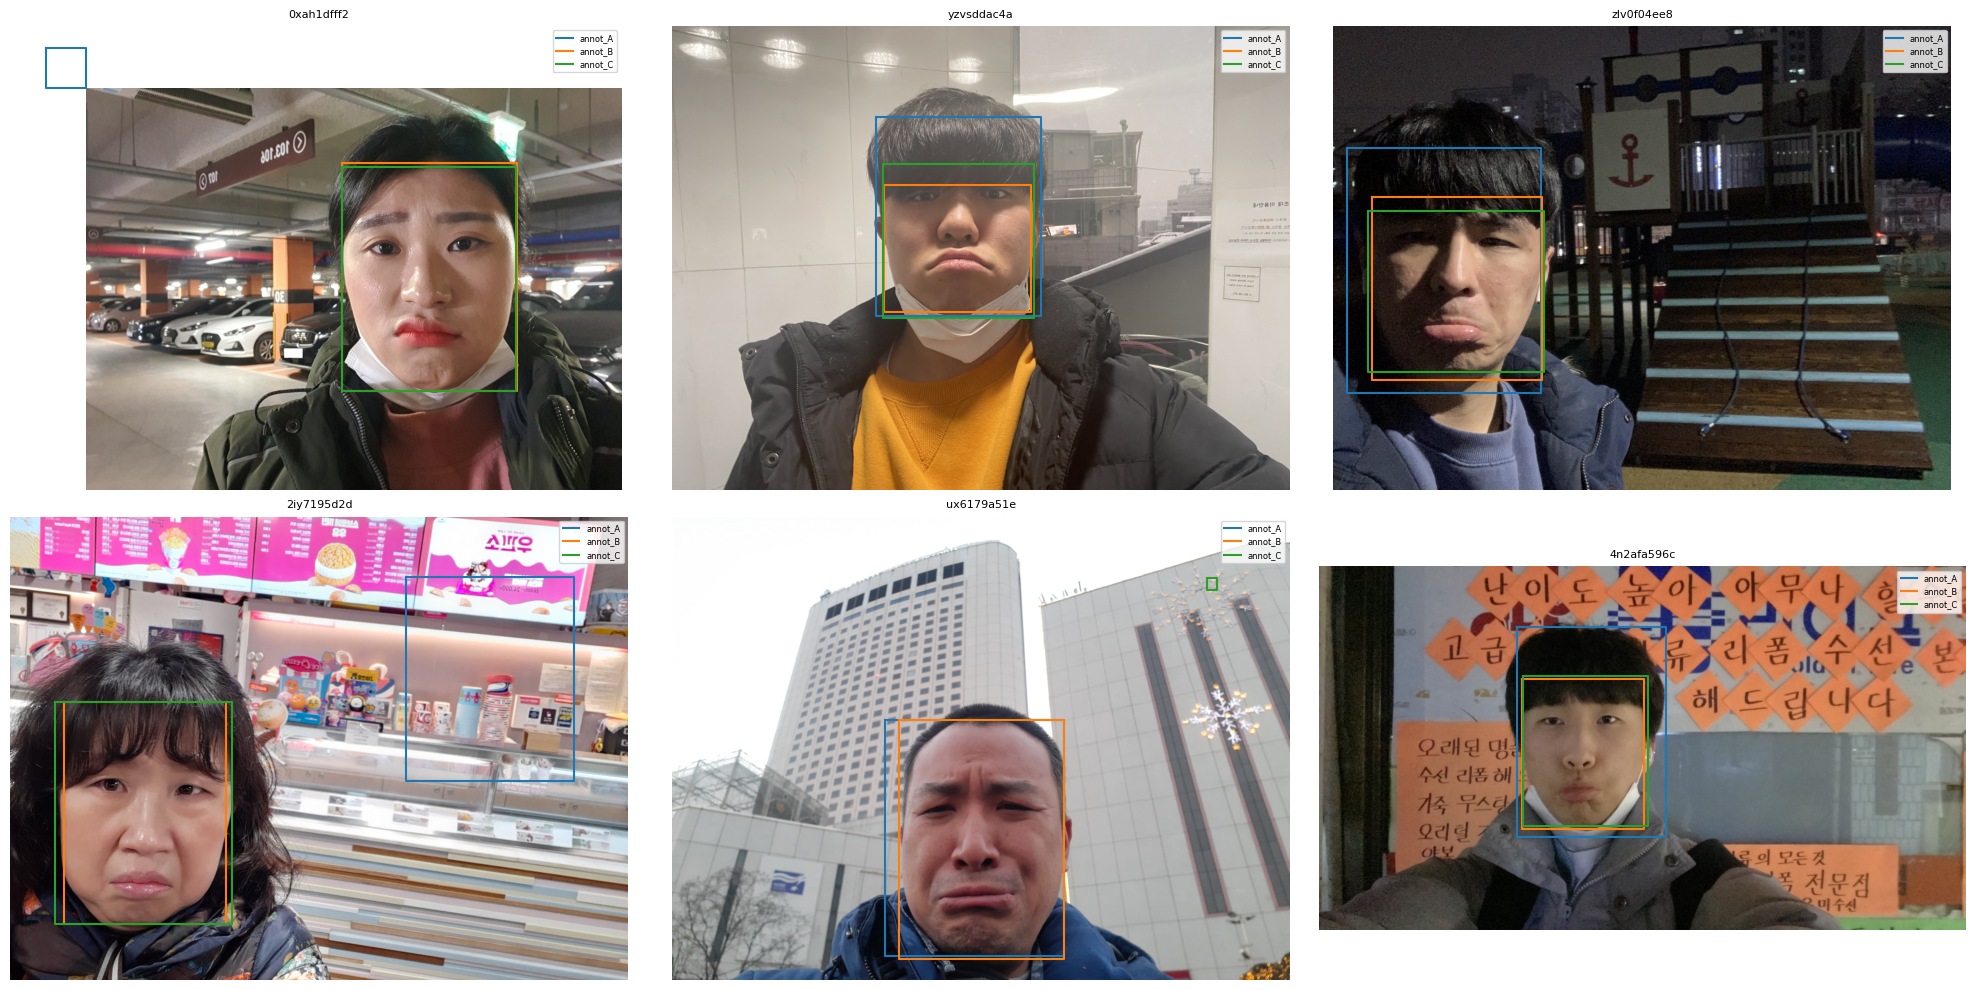

In [28]:
# outlier 시각화

# 이미지,박스 시각화 함수 정의
def visualize_boxes(data, image_dir):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.ravel()

    for idx, item in enumerate(data):
        filename = item['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            continue

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image) 
        axes[idx].axis('off')

        # Plot boxes from annotations
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            if annot_key in item:
                box = item[annot_key]['boxes']
                x = [box['minX'], box['maxX'], box['maxX'], box['minX'], box['minX']]
                y = [box['minY'], box['minY'], box['maxY'], box['maxY'], box['minY']]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)
       
    # Hide unused subplots
    for i in range(len(data), 6):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
visualize_boxes(outlier_json_sadness, sadness_img_path)

In [29]:
# outlier 데이터 좌표 출력

def format_boxes(box):
    return {key: round(value, 2) for key, value in box.items()}

def print_outlier_coordinates(outlier_data):
    for i, entry in enumerate(outlier_data):
        print(f"Outlier {i+1}:")
        print(f"Filename: {entry['filename']}")
        print(f"  annot_A: {format_boxes(entry['annot_A']['boxes'])}")
        print(f"  annot_B: {format_boxes(entry['annot_B']['boxes'])}")
        print(f"  annot_C: {format_boxes(entry['annot_C']['boxes'])}")
        print("-" * 50)

print_outlier_coordinates(outlier_json_sadness)

Outlier 1:
Filename: 0xah1dfff2988dd0bb1002299e49a2e81221721df2086792404682f191894jnl2.jpg
  annot_A: {'maxX': 0, 'maxY': 0, 'minX': -221.24, 'minY': -219.05}
  annot_B: {'maxX': 2369.76, 'maxY': 1668.09, 'minX': 1407.36, 'minY': 414.56}
  annot_C: {'maxX': 2367.09, 'maxY': 1663.46, 'minX': 1411.49, 'minY': 435.68}
--------------------------------------------------
Outlier 2:
Filename: yzvsddac4a0d3d5fca4399b4cb5c9174204b560155f724cbd520e271422d4z2mb.jpg
  annot_A: {'maxX': 2412.6, 'maxY': 1892.16, 'minX': 1330.3, 'minY': 593.6}
  annot_B: {'maxX': 2345.07, 'maxY': 1862.63, 'minX': 1387.34, 'minY': 1037.16}
  annot_C: {'maxX': 2364.46, 'maxY': 1904.19, 'minX': 1380.74, 'minY': 899.33}
--------------------------------------------------
Outlier 3:
Filename: zlv0f04ee8afdbd37afcb9a39f404043fac43dc76fd6357c67ac421764624tjjy.jpg
  annot_A: {'maxX': 1035.94, 'maxY': 1834.16, 'minX': 65.93, 'minY': 606.67}
  annot_B: {'maxX': 1044.66, 'maxY': 1770.62, 'minX': 191.24, 'minY': 854.59}
  annot_C